In [202]:
import dlc_practical_prologue as plg
from torch import nn
from torch.nn import functional as F
import torch
from operator import mul as multiplicator
from functools import reduce

In [203]:
if (torch.cuda.is_available()):
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [216]:
train_classes.shape

torch.Size([1000, 2])

In [217]:
train_classes[0:1,:]

tensor([[1, 2]], device='cuda:0')

In [204]:
N = 1000
train_input, train_target, train_classes, test_input, test_target, test_classes = plg.generate_pair_sets(N)
train_input = train_input.to(device)
train_target = train_target.to(device)
train_classes = train_classes.to(device)
test_input = test_input.to(device)
test_target = test_target.to(device)
test_classes = test_classes.to(device)

In [4]:
# Normalization
mu, std = train_input.mean(), train_input.std()
train_input = train_input.sub(mu).div(std)
test_input = test_input.sub(mu).div(std)

# Baseline: simple network trained with cross entropy

In [165]:
class Net(nn.Module):
    def __init__(self, nb_hidden1 = 50, nb_hidden2 = 10):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(2, 8, kernel_size=3, padding=2)
        self.avgpool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, dilation=1)
        #self.conv3 = nn.Conv2d(16, 32, kernel_size=3)
        self.fc1 = nn.Linear(16 * 3 * 3, nb_hidden1)
        self.fc2 = nn.Linear(nb_hidden1, nb_hidden2)
        self.fc3 = nn.Linear(nb_hidden2, 2)

    def forward(self, x):
        x = F.relu(self.avgpool1(self.conv1(x)))
        x = F.relu(self.maxpool1(self.conv2(x)))
        x = F.relu(self.fc1(x.view(-1, 16*3*3)))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [166]:
# Number of params
params = sum([np.prod(p.size()) for p in Net().parameters()])
params

9102

In [167]:
class Net2(nn.Module):
    def __init__(self, nb_hidden1 = 50, nb_hidden2 = 10):
        super(Net2, self).__init__()
        self.conv1 = nn.Conv2d(2, 8, kernel_size=3, groups=2)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, dilation=1)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=2)
        self.fc1 = nn.Linear(32*2*2, nb_hidden1)
        self.fc2 = nn.Linear(nb_hidden1, nb_hidden2)
        self.fc3 = nn.Linear(nb_hidden2, 2)

    def forward(self, x):
        x = F.relu(self.maxpool1(self.conv1(x)))
        x = F.relu(self.maxpool2(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = F.relu(self.fc1(x.view(-1, 32*2*2)))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [168]:
# Number of params
params = sum([np.prod(p.size()) for p in Net2().parameters()])
params

10310

In [169]:
# Check on the sizes
X = torch.empty((1, 2, 14, 14)).normal_()
net = Net()
for layer in net.children():
    if isinstance(layer, nn.Linear):
        X = X.view(-1, reduce(multiplicator, list(X.shape[1:])))
    X = layer(X)
    print(layer, 'output shape:\t', X.shape)

Conv2d(2, 8, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2)) output shape:	 torch.Size([1, 8, 16, 16])
AvgPool2d(kernel_size=2, stride=2, padding=0) output shape:	 torch.Size([1, 8, 8, 8])
Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1)) output shape:	 torch.Size([1, 16, 6, 6])
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) output shape:	 torch.Size([1, 16, 3, 3])
Linear(in_features=144, out_features=50, bias=True) output shape:	 torch.Size([1, 50])
Linear(in_features=50, out_features=10, bias=True) output shape:	 torch.Size([1, 10])
Linear(in_features=10, out_features=2, bias=True) output shape:	 torch.Size([1, 2])


In [20]:
# Check on the sizes
X = torch.empty((1, 2, 14, 14)).normal_()
net = Net2()
for layer in net.children():
    if isinstance(layer, nn.Linear):
        X = X.view(-1, reduce(multiplicator, list(X.shape[1:])))
    X = layer(X)
    print(layer, 'output shape:\t', X.shape)

Conv2d(2, 8, kernel_size=(3, 3), stride=(1, 1), groups=2) output shape:	 torch.Size([1, 8, 12, 12])
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) output shape:	 torch.Size([1, 8, 6, 6])
Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) output shape:	 torch.Size([1, 16, 6, 6])
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) output shape:	 torch.Size([1, 16, 3, 3])
Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1)) output shape:	 torch.Size([1, 32, 2, 2])
Linear(in_features=128, out_features=50, bias=True) output shape:	 torch.Size([1, 50])
Linear(in_features=50, out_features=10, bias=True) output shape:	 torch.Size([1, 10])
Linear(in_features=10, out_features=2, bias=True) output shape:	 torch.Size([1, 2])


In [7]:
def train_model(model, train_input, train_target, mini_batch_size, criterion, epochs, eta, optim="SGD", momentum = 0, nesterov = False):
    
    if (optim == "SGD"):
        optimizer = torch.optim.SGD(model.parameters(), lr = eta, momentum = momentum, nesterov = nesterov)
    if (optim == "Adam"):
        optimizer = torch.optim.Adam(model.parameters(), lr = eta)
        
    for e in range(0, epochs):
        for input_data, target_data in zip(train_input.split(mini_batch_size), train_target.split(mini_batch_size)):
            output = model(input_data)
            loss = criterion(output, target_data)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

In [8]:
def compute_nb_errors(model, data_input, data_target, mini_batch_size):
    tot_err = 0
    for input_data, target_data in zip(data_input.split(mini_batch_size), data_target.split(mini_batch_size)):
        res = model(input_data)
        for i, r in enumerate(res):
            pred = r.max(0)[1].item()
            if(target_data[i])!=pred:
                tot_err+=1
    return tot_err

In [ ]:
def compute_nb_errors_siamese(model, data_input, data_target, mini_batch_size):
    tot_err = 0
    for input_data, target_data in zip(data_input.split(mini_batch_size), data_target.split(mini_batch_size)):
        res, _= model(input_data)
        for i, r in enumerate(res):
            pred = r.max(0)[1].item()
            if(target_data[i])!=pred:
                tot_err+=1
    return tot_err

## First Net

## SGD 

In [9]:
model = Net().to(device)
criterion = nn.CrossEntropyLoss().to(device)
mini_batch_size = 100
epochs = 250
eta = 0.01
train_model(model, train_input, train_target, mini_batch_size, criterion, epochs, eta)

In [10]:
compute_nb_errors(model, train_input, train_target, mini_batch_size)

232

In [11]:
compute_nb_errors(model, test_input, test_target, mini_batch_size)

228

### Optimize over eta (simple optimize)

In [12]:
mini_batch_size = 100
epochs = 100
etas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
N = 10
for eta in etas:
    tot_eta = 0
    for i in range(0, N):
        model = Net().to(device)
        criterion = nn.CrossEntropyLoss().to(device)
        train_model(model, train_input, train_target, mini_batch_size, criterion, epochs, eta)
        err = compute_nb_errors(model, test_input, test_target, mini_batch_size)
        tot_eta+=err
    print("Eta = {}, avg_err = {}".format(eta, tot_eta/N))

Eta = 1e-05, avg_err = 500.0
Eta = 0.0001, avg_err = 489.6
Eta = 0.001, avg_err = 494.1
Eta = 0.01, avg_err = 462.8
Eta = 0.1, avg_err = 215.1


### Optimize over eta, momentum, nesterov

In [13]:
mini_batch_size = 100
epochs = 100
etas = [1e-4, 1e-3, 1e-2, 1e-1]
momentum = [1e-4, 1e-3, 1e-2, 1e-1]
N = 3
for eta in etas:
    for m in momentum:
        for nest in [False, True]:
            tot_eta = 0
            for i in range(0, N):
                model = Net().to(device)
                criterion = nn.CrossEntropyLoss().to(device)
                train_model(model, train_input, train_target, mini_batch_size, criterion, epochs, eta, "SGD", m, nest)
                err = compute_nb_errors(model, test_input, test_target, mini_batch_size)
                tot_eta+=err
            print("Eta = {}, momentum = {}, nesterov = {}, avg_err = {}".format(eta, m, nest, tot_eta/N))

Eta = 0.0001, momentum = 0.0001, nesterov = False, avg_err = 501.3333333333333
Eta = 0.0001, momentum = 0.0001, nesterov = True, avg_err = 491.3333333333333
Eta = 0.0001, momentum = 0.001, nesterov = False, avg_err = 482.0
Eta = 0.0001, momentum = 0.001, nesterov = True, avg_err = 491.3333333333333
Eta = 0.0001, momentum = 0.01, nesterov = False, avg_err = 491.3333333333333
Eta = 0.0001, momentum = 0.01, nesterov = True, avg_err = 474.0
Eta = 0.0001, momentum = 0.1, nesterov = False, avg_err = 491.3333333333333
Eta = 0.0001, momentum = 0.1, nesterov = True, avg_err = 487.0
Eta = 0.001, momentum = 0.0001, nesterov = False, avg_err = 508.3333333333333
Eta = 0.001, momentum = 0.0001, nesterov = True, avg_err = 508.6666666666667
Eta = 0.001, momentum = 0.001, nesterov = False, avg_err = 473.6666666666667
Eta = 0.001, momentum = 0.001, nesterov = True, avg_err = 474.0
Eta = 0.001, momentum = 0.01, nesterov = False, avg_err = 491.3333333333333
Eta = 0.001, momentum = 0.01, nesterov = True, a

## Adam

In [14]:
model = Net().to(device)
criterion = nn.CrossEntropyLoss().to(device)
mini_batch_size = 100
epochs = 250
eta = 0.01
train_model(model, train_input, train_target, mini_batch_size, criterion, epochs, eta, "Adam")

In [15]:
compute_nb_errors(model, train_input, train_target, mini_batch_size)

0

In [16]:
compute_nb_errors(model, test_input, test_target, mini_batch_size)

206

### Optimize over eta (simple optimize)

In [17]:
mini_batch_size = 100
epochs = 100
etas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
N = 10
for eta in etas:
    tot_eta = 0
    for i in range(0, N):
        model = Net().to(device)
        criterion = nn.CrossEntropyLoss().to(device)
        train_model(model, train_input, train_target, mini_batch_size, criterion, epochs, eta, "Adam")
        err = compute_nb_errors(model, test_input, test_target, mini_batch_size)
        tot_eta+=err
    print("Eta = {}, avg_err = {}".format(eta, tot_eta/N))

Eta = 1e-05, avg_err = 480.7
Eta = 0.0001, avg_err = 210.5
Eta = 0.001, avg_err = 194.0
Eta = 0.01, avg_err = 211.0
Eta = 0.1, avg_err = 474.0


## Second Net

## SGD 

In [21]:
model = Net2().to(device)
criterion = nn.CrossEntropyLoss().to(device)
mini_batch_size = 100
epochs = 250
eta = 0.01
train_model(model, train_input, train_target, mini_batch_size, criterion, epochs, eta)

In [22]:
compute_nb_errors(model, train_input, train_target, mini_batch_size)

249

In [23]:
compute_nb_errors(model, test_input, test_target, mini_batch_size)

263

### Optimize over eta (simple optimize)

In [24]:
mini_batch_size = 100
epochs = 100
etas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
N = 10
for eta in etas:
    tot_eta = 0
    for i in range(0, N):
        model = Net2().to(device)
        criterion = nn.CrossEntropyLoss().to(device)
        train_model(model, train_input, train_target, mini_batch_size, criterion, epochs, eta)
        err = compute_nb_errors(model, test_input, test_target, mini_batch_size)
        tot_eta+=err
    print("Eta = {}, avg_err = {}".format(eta, tot_eta/N))

Eta = 1e-05, avg_err = 489.6
Eta = 0.0001, avg_err = 498.4
Eta = 0.001, avg_err = 489.5
Eta = 0.01, avg_err = 456.1
Eta = 0.1, avg_err = 213.6


### Optimize over eta, momentum, nesterov

In [25]:
mini_batch_size = 100
epochs = 100
etas = [1e-4, 1e-3, 1e-2, 1e-1]
momentum = [1e-4, 1e-3, 1e-2, 1e-1]
N = 3
for eta in etas:
    for m in momentum:
        for nest in [False, True]:
            tot_eta = 0
            for i in range(0, N):
                model = Net2().to(device)
                criterion = nn.CrossEntropyLoss().to(device)
                train_model(model, train_input, train_target, mini_batch_size, criterion, epochs, eta, "SGD", m, nest)
                err = compute_nb_errors(model, test_input, test_target, mini_batch_size)
                tot_eta+=err
            print("Eta = {}, momentum = {}, nesterov = {}, avg_err = {}".format(eta, m, nest, tot_eta/N))

Eta = 0.0001, momentum = 0.0001, nesterov = False, avg_err = 508.6666666666667
Eta = 0.0001, momentum = 0.0001, nesterov = True, avg_err = 526.0
Eta = 0.0001, momentum = 0.001, nesterov = False, avg_err = 474.0
Eta = 0.0001, momentum = 0.001, nesterov = True, avg_err = 508.6666666666667
Eta = 0.0001, momentum = 0.01, nesterov = False, avg_err = 491.3333333333333
Eta = 0.0001, momentum = 0.01, nesterov = True, avg_err = 491.3333333333333
Eta = 0.0001, momentum = 0.1, nesterov = False, avg_err = 514.3333333333334
Eta = 0.0001, momentum = 0.1, nesterov = True, avg_err = 508.6666666666667
Eta = 0.001, momentum = 0.0001, nesterov = False, avg_err = 491.3333333333333
Eta = 0.001, momentum = 0.0001, nesterov = True, avg_err = 491.3333333333333
Eta = 0.001, momentum = 0.001, nesterov = False, avg_err = 474.0
Eta = 0.001, momentum = 0.001, nesterov = True, avg_err = 474.0
Eta = 0.001, momentum = 0.01, nesterov = False, avg_err = 474.0
Eta = 0.001, momentum = 0.01, nesterov = True, avg_err = 474

## Adam

In [26]:
model = Net2().to(device)
criterion = nn.CrossEntropyLoss().to(device)
mini_batch_size = 100
epochs = 250
eta = 0.01
train_model(model, train_input, train_target, mini_batch_size, criterion, epochs, eta, "Adam")

In [27]:
compute_nb_errors(model, train_input, train_target, mini_batch_size)

0

In [28]:
compute_nb_errors(model, test_input, test_target, mini_batch_size)

198

### Optimize over eta (simple optimize)

In [29]:
mini_batch_size = 100
epochs = 100
etas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
N = 10
for eta in etas:
    tot_eta = 0
    for i in range(0, N):
        model = Net2().to(device)
        criterion = nn.CrossEntropyLoss().to(device)
        train_model(model, train_input, train_target, mini_batch_size, criterion, epochs, eta, "Adam")
        err = compute_nb_errors(model, test_input, test_target, mini_batch_size)
        tot_eta+=err
    print("Eta = {}, avg_err = {}".format(eta, tot_eta/N))

Eta = 1e-05, avg_err = 484.4
Eta = 0.0001, avg_err = 202.2
Eta = 0.001, avg_err = 210.5
Eta = 0.01, avg_err = 200.7
Eta = 0.1, avg_err = 474.0


# Network 2: siamese network with weight sharing and auxiliary losses

In [520]:
class SiameseNet(nn.Module):
    def __init__(self, chan1 = 16, chan2 = 32, chan3 = 64, nb_hidden1 = 100, nb_hidden2 = 50, nb_hidden3 = 50, nb_hidden4 = 10):
        super(SiameseNet, self).__init__()
        
        self.features = nn.Sequential()
        self.features.add_module("conv_1", nn.Conv2d(1, chan1, kernel_size=3))
        self.features.add_module("relu_1", nn.ReLU())
        self.features.add_module("maxpool_1", nn.MaxPool2d(kernel_size=2))
        self.features.add_module("conv_2", nn.Conv2d(chan1, chan2, kernel_size=2))
        self.features.add_module("relu_2", nn.ReLU())
        self.features.add_module("maxpool2", nn.MaxPool2d(kernel_size=2, dilation=1))
        self.features.add_module("conv_3", nn.Conv2d(chan2, chan3, kernel_size=2))
        self.features.add_module("relu_3", nn.ReLU())
        
        class_size = self.features(torch.empty((1, 1, 14, 14))).shape
        self.linear_size = reduce(multiplicator, list(class_size[1:]))
        
        self.classifier1 = nn.Sequential()
        self.classifier1.add_module("linear_1", nn.Linear(self.linear_size, nb_hidden1))
        self.classifier1.add_module("relu_1", nn.ReLU())
        self.classifier1.add_module("dropout_1", nn.Dropout(0.25))
        self.classifier1.add_module("linear_2", nn.Linear(nb_hidden1, nb_hidden2))
        self.classifier1.add_module("relu_2", nn.ReLU())
        self.classifier1.add_module("dropout_2", nn.Dropout(0.25))
        self.classifier1.add_module("linear_3", nn.Linear(nb_hidden2, 10))
        
        self.classifier2 = nn.Sequential()
        self.classifier2.add_module("linear_1", nn.Linear(10, nb_hidden3))
        self.classifier2.add_module("relu_1", nn.ReLU())
        self.classifier2.add_module("dropout_1", nn.Dropout(0.25))
        self.classifier2.add_module("linear_2", nn.Linear(nb_hidden3, nb_hidden4))
        self.classifier2.add_module("relu_2", nn.ReLU())
        self.classifier2.add_module("dropout_2", nn.Dropout(0.25))
        self.classifier2.add_module("linear_3", nn.Linear(nb_hidden4, 2))
        

    def forward(self, x):
        out_aux = []
        for i in range(0, 2):
            x_i = x[:,i,:,:].view((x.shape[0], 1) + tuple(x.shape[2:]))
            x_i = self.features(x_i)
            out_aux.append(self.classifier1(x_i.view(-1, self.linear_size)))
        #diff = out_aux[1] - out_aux[0]
        diff = torch.cat((out_aux[1], out_aux[0]), 1)
        out = self.classifier2(diff)
        return out, out_aux

In [9]:
# Check on the sizes
X = torch.empty((1, 1, 14, 14)).normal_()
net = SiameseNet()
for layer in net.features:
    if isinstance(layer, nn.Linear):
        X = X.view(-1, reduce(multiplicator, list(X.shape[1:])))
    X = layer(X)
    print(layer, 'output shape:\t', X.shape)

Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1)) output shape:	 torch.Size([1, 16, 12, 12])
ReLU() output shape:	 torch.Size([1, 16, 12, 12])
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) output shape:	 torch.Size([1, 16, 6, 6])
Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1)) output shape:	 torch.Size([1, 32, 5, 5])
ReLU() output shape:	 torch.Size([1, 32, 5, 5])
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) output shape:	 torch.Size([1, 32, 2, 2])
Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1)) output shape:	 torch.Size([1, 64, 1, 1])
ReLU() output shape:	 torch.Size([1, 64, 1, 1])


In [23]:
def train_siamese(model, train_input, train_target, train_classes, mini_batch_size, criterion, epochs, eta, optim="SGD", momentum = 0, nesterov = False):
    
    if (optim == "SGD"):
        optimizer = torch.optim.SGD(model.parameters(), lr = eta, momentum = momentum, nesterov = nesterov)
    if (optim == "Adam"):
        optimizer = torch.optim.Adam(model.parameters(), lr = eta)
        
    for e in range(0, epochs):
        for input_data, target_data, class_data in zip(train_input.split(mini_batch_size), train_target.split(mini_batch_size), train_classes.split(mini_batch_size)):
            output, out_aux = model(input_data)
            loss_out = criterion(output, target_data)
            loss_aux0 = criterion(out_aux[0], class_data[:,0])
            loss_aux1 = criterion(out_aux[1], class_data[:,1])
            loss = loss_out + loss_aux0 + loss_aux1
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

In [293]:
def train_siamese_losses(model, train_input, train_target, train_classes, test_input, test_classes, test_target, 
                         mini_batch_size, criterion, epochs, eta, optim="SGD", momentum = 0, nesterov = False):
    
    if (optim == "SGD"):
        optimizer = torch.optim.SGD(model.parameters(), lr = eta, momentum = momentum, nesterov = nesterov)
    if (optim == "Adam"):
        optimizer = torch.optim.Adam(model.parameters(), lr = eta)
    
    loss0 = {"train": [], "test": []}
    loss1 = {"train": [], "test":[]}
    loss_class = {"train":[], "test":[]}
    loss_tot = {"train": [], "test":[]}
    acc = {"train": [], "test": []}
        
    for e in range(0, epochs):
        loss_sum0_train = 0
        loss_sum1_train = 0
        loss_sumclass_train = 0
        loss_sumtot_train = 0
        
        model.train(True)
        for input_data, target_data, class_data in zip(train_input.split(mini_batch_size), train_target.split(mini_batch_size), train_classes.split(mini_batch_size)):
            output, out_aux = model(input_data)
            loss_out = criterion(output, target_data)
            loss_aux0 = criterion(out_aux[0], class_data[:,0])
            loss_aux1 = criterion(out_aux[1], class_data[:,1])
            loss = loss_out + loss_aux0 + loss_aux1
            
            loss_sum0_train+=loss_aux0
            loss_sum1_train+=loss_aux1
            loss_sumclass_train+=loss_out
            loss_sumtot_train+=loss
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        loss0['train'].append(loss_sum0_train/10)
        loss1['train'].append(loss_sum1_train/10)
        loss_class['train'].append(loss_sumclass_train/10)
        loss_tot['train'].append(loss_sumtot_train/10)
        
        with torch.no_grad():
            acc['train'].append(compute_nb_errors_siamese(model, train_input, train_target, mini_batch_size)/10)
            model.train(False)
            loss_0_test, loss_1_test, loss_class_test, loss_tot_test = compute_losses_test(model, test_input, test_target, test_classes, mini_batch_size)
            loss0['test'].append(loss_0_test)
            loss1['test'].append(loss_1_test)
            loss_class['test'].append(loss_class_test)
            loss_tot['test'].append(loss_tot_test)
            acc['test'].append(compute_nb_errors_siamese(model, test_input, test_target, mini_batch_size)/10)
            
    return loss0, loss1, loss_class, loss_tot, acc

In [139]:
def compute_losses_test(model, test_input, test_target, test_classes, mini_batch_size):
    with torch.no_grad():
        loss_sum0_test = 0
        loss_sum1_test = 0
        loss_sumclass_test = 0
        loss_sumtot_test = 0
        for input_data, target_data, class_data in zip(test_input.split(mini_batch_size), test_target.split(mini_batch_size), test_classes.split(mini_batch_size)):
            output, out_aux = model(input_data)
            loss_out = criterion(output, target_data)
            loss_aux0 = criterion(out_aux[0], class_data[:,0])
            loss_aux1 = criterion(out_aux[1], class_data[:,1])
            loss = loss_out + loss_aux0 + loss_aux1

            loss_sum0_test+=loss_aux0
            loss_sum1_test+=loss_aux1
            loss_sumclass_test+=loss_out
            loss_sumtot_test+=loss
    
    return loss_sum0_test/10, loss_sum1_test/10, loss_sumclass_test/10, loss_sumtot_test/10

In [7]:
def compute_nb_errors_siamese(model, data_input, data_target, mini_batch_size):
    tot_err = 0
    for input_data, target_data in zip(data_input.split(mini_batch_size), data_target.split(mini_batch_size)):
        res, _= model(input_data)
        for i, r in enumerate(res):
            pred = r.max(0)[1].item()
            if(target_data[i])!=pred:
                tot_err+=1
    return tot_err

## SGD 

In [94]:
del model
model = SiameseNet().to(device)
criterion = nn.CrossEntropyLoss().to(device)
mini_batch_size = 100
epochs = 250
eta = 0.01
train_siamese(model, train_input, train_target, train_classes, mini_batch_size, criterion, epochs, eta)

In [95]:
compute_nb_errors_siamese(model, train_input, train_target, mini_batch_size)

53

In [96]:
compute_nb_errors_siamese(model, test_input, test_target, mini_batch_size)

130

### Optimize over eta (simple optimize)

In [98]:
mini_batch_size = 100
epochs = 100
etas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
N = 10
for eta in etas:
    tot_eta = 0
    for i in range(0, N):
        del model
        model = SiameseNet().to(device)
        criterion = nn.CrossEntropyLoss().to(device)
        train_siamese(model, train_input, train_target, train_classes, mini_batch_size, criterion, epochs, eta)
        err = compute_nb_errors_siamese(model, test_input, test_target, mini_batch_size)
        tot_eta+=err
    print("Eta = {}, avg_err = {}".format(eta, tot_eta/N))

Eta = 1e-05, avg_err = 505.2
Eta = 0.0001, avg_err = 505.9
Eta = 0.001, avg_err = 484.4
Eta = 0.01, avg_err = 255.6
Eta = 0.1, avg_err = 89.6


### Optimize over eta, momentum, nesterov

In [100]:
mini_batch_size = 100
epochs = 100
etas = [1e-4, 1e-3, 1e-2, 1e-1]
momentum = [1e-4, 1e-3, 1e-2, 1e-1]
N = 3
for eta in etas:
    for m in momentum:
        for nest in [False, True]:
            tot_eta = 0
            for i in range(0, N):
                del model
                model = SiameseNet().to(device)
                criterion = nn.CrossEntropyLoss().to(device)
                train_siamese(model, train_input, train_target, train_classes, mini_batch_size, criterion, epochs, eta, "SGD", m, nest)
                err = compute_nb_errors_siamese(model, test_input, test_target, mini_batch_size)
                tot_eta+=err
            print("Eta = {}, momentum = {}, nesterov = {}, avg_err = {}".format(eta, m, nest, tot_eta/N))

Eta = 0.0001, momentum = 0.0001, nesterov = False, avg_err = 508.6666666666667
Eta = 0.0001, momentum = 0.0001, nesterov = True, avg_err = 491.3333333333333
Eta = 0.0001, momentum = 0.001, nesterov = False, avg_err = 508.6666666666667
Eta = 0.0001, momentum = 0.001, nesterov = True, avg_err = 491.3333333333333
Eta = 0.0001, momentum = 0.01, nesterov = False, avg_err = 491.3333333333333
Eta = 0.0001, momentum = 0.01, nesterov = True, avg_err = 491.3333333333333
Eta = 0.0001, momentum = 0.1, nesterov = False, avg_err = 474.0
Eta = 0.0001, momentum = 0.1, nesterov = True, avg_err = 526.0
Eta = 0.001, momentum = 0.0001, nesterov = False, avg_err = 474.0
Eta = 0.001, momentum = 0.0001, nesterov = True, avg_err = 508.6666666666667
Eta = 0.001, momentum = 0.001, nesterov = False, avg_err = 491.3333333333333
Eta = 0.001, momentum = 0.001, nesterov = True, avg_err = 474.0
Eta = 0.001, momentum = 0.01, nesterov = False, avg_err = 474.0
Eta = 0.001, momentum = 0.01, nesterov = True, avg_err = 474

## Adam

In [13]:
del model
model = SiameseNet().to(device)
criterion = nn.CrossEntropyLoss().to(device)
mini_batch_size = 100
epochs = 250
eta = 0.01
train_siamese(model, train_input, train_target, train_classes, mini_batch_size, criterion, epochs, eta, "Adam")

In [14]:
compute_nb_errors_siamese(model, train_input, train_target, mini_batch_size)

0

In [15]:
compute_nb_errors_siamese(model, test_input, test_target, mini_batch_size)

68

### Optimize over eta (simple optimize)

In [114]:
mini_batch_size = 100
epochs = 100
etas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
N = 10
for eta in etas:
    tot_eta = 0
    for i in range(0, N):
        del model
        model = SiameseNet().to(device)
        criterion = nn.CrossEntropyLoss().to(device)
        train_siamese(model, train_input, train_target, train_classes, mini_batch_size, criterion, epochs, eta, "Adam")
        err = compute_nb_errors_siamese(model, test_input, test_target, mini_batch_size)
        tot_eta+=err
    print("Eta = {}, avg_err = {}".format(eta, tot_eta/N))

Eta = 1e-05, avg_err = 490.5
Eta = 0.0001, avg_err = 215.1
Eta = 0.001, avg_err = 119.9
Eta = 0.01, avg_err = 73.0
Eta = 0.1, avg_err = 459.0


## Printing losses

In [508]:
del model
model = SiameseNet().to(device)
criterion = nn.CrossEntropyLoss().to(device)
mini_batch_size = 100
epochs = 50
eta = 0.005
loss0, loss1, loss_class, loss_tot, acc = train_siamese_losses(model, train_input, train_target, train_classes, test_input, test_classes, test_target, 
                                                               mini_batch_size, criterion, epochs, eta, optim="Adam")

In [509]:
compute_nb_errors_siamese(model, test_input, test_target, mini_batch_size)

48

In [510]:
# Number of params
params = sum([np.prod(p.size()) for p in model.parameters()])
params

89964

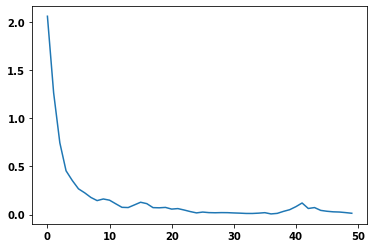

In [511]:
import matplotlib.pyplot as plt
import numpy as np

epochs_range = np.arange(0, epochs)
plt.plot(epochs_range, loss0['train'])

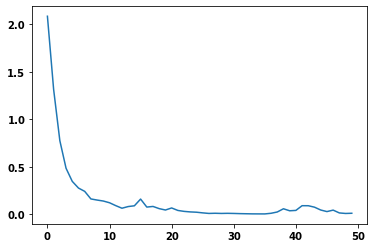

In [512]:
plt.plot(epochs_range, loss1['train'])

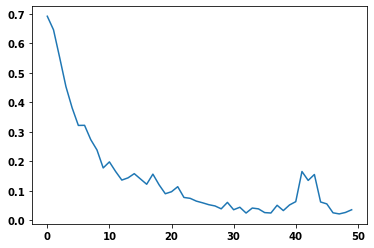

In [513]:
plt.plot(epochs_range, loss_class['train'])

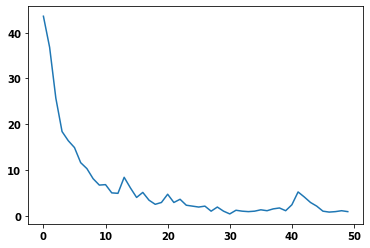

In [514]:
plt.plot(epochs_range, acc['train'])

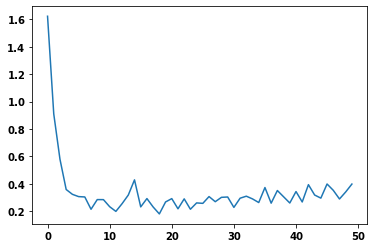

In [515]:
plt.plot(epochs_range, loss0['test'])

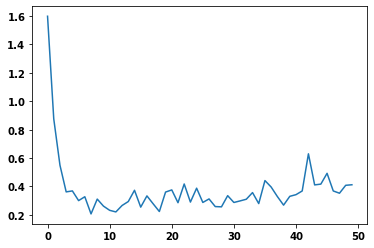

In [516]:
plt.plot(epochs_range, loss1['test'])

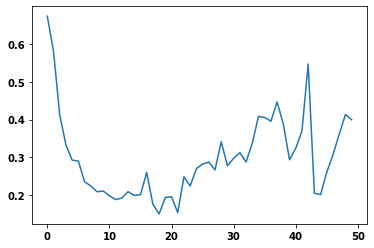

In [517]:
plt.plot(epochs_range, loss_class['test'])

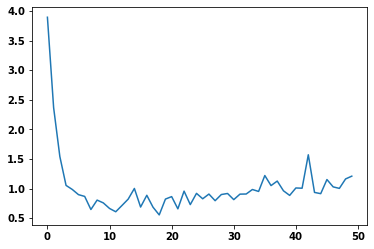

In [518]:
plt.plot(epochs_range, loss_tot['test'])

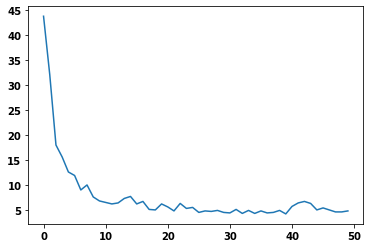

In [519]:
plt.plot(epochs_range, acc['test'])

In [15]:
class NonSiameseNet(nn.Module):
    def __init__(self, chan1 = 16, chan2 = 32, chan3 = 64, nb_hidden1 = 100, nb_hidden2 = 50, nb_hidden3 = 50, nb_hidden4 = 10):
        super(NonSiameseNet, self).__init__()
        
        self.features1 = nn.Sequential()
        self.features1.add_module("conv_1", nn.Conv2d(1, chan1, kernel_size=3))
        self.features1.add_module("relu_1", nn.ReLU())
        self.features1.add_module("maxpool_1", nn.MaxPool2d(kernel_size=2))
        self.features1.add_module("conv_2", nn.Conv2d(chan1, chan2, kernel_size=2))
        self.features1.add_module("relu_2", nn.ReLU())
        self.features1.add_module("maxpool2", nn.MaxPool2d(kernel_size=2, dilation=1))
        self.features1.add_module("conv_3", nn.Conv2d(chan2, chan3, kernel_size=2))
        self.features1.add_module("relu_3", nn.ReLU())
        
        self.features2 = nn.Sequential()
        self.features2.add_module("conv_1", nn.Conv2d(1, chan1, kernel_size=3))
        self.features2.add_module("relu_1", nn.ReLU())
        self.features2.add_module("maxpool_1", nn.MaxPool2d(kernel_size=2))
        self.features2.add_module("conv_2", nn.Conv2d(chan1, chan2, kernel_size=2))
        self.features2.add_module("relu_2", nn.ReLU())
        self.features2.add_module("maxpool2", nn.MaxPool2d(kernel_size=2, dilation=1))
        self.features2.add_module("conv_3", nn.Conv2d(chan2, chan3, kernel_size=2))
        self.features2.add_module("relu_3", nn.ReLU())
        
        class_size = self.features1(torch.empty((1, 1, 14, 14))).shape
        self.linear_size = reduce(multiplicator, list(class_size[1:]))
        
        self.classifier1 = nn.Sequential()
        self.classifier1.add_module("linear_1", nn.Linear(self.linear_size, nb_hidden1))
        self.classifier1.add_module("relu_1", nn.ReLU())
        self.classifier1.add_module("linear_2", nn.Linear(nb_hidden1, nb_hidden2))
        self.classifier1.add_module("relu_2", nn.ReLU())
        self.classifier1.add_module("linear_3", nn.Linear(nb_hidden2, 10))
        
        self.classifier2 = nn.Sequential()
        self.classifier2.add_module("linear_1", nn.Linear(self.linear_size, nb_hidden1))
        self.classifier2.add_module("relu_1", nn.ReLU())
        self.classifier2.add_module("linear_2", nn.Linear(nb_hidden1, nb_hidden2))
        self.classifier2.add_module("relu_2", nn.ReLU())
        self.classifier2.add_module("linear_3", nn.Linear(nb_hidden2, 10))
        
        self.classifierf = nn.Sequential()
        self.classifierf.add_module("linear_1", nn.Linear(20, nb_hidden3))
        self.classifierf.add_module("relu_1", nn.ReLU())
        self.classifierf.add_module("linear_2", nn.Linear(nb_hidden3, nb_hidden4))
        self.classifierf.add_module("relu_2", nn.ReLU())
        self.classifierf.add_module("linear_3", nn.Linear(nb_hidden4, 2))
        

    def forward(self, x):
        out_aux = []
        
        x_1 = x[:,0,:,:].view((x.shape[0], 1) + tuple(x.shape[2:]))
        x_1 = self.features1(x_1)
        out_aux.append(self.classifier1(x_1.view(-1, self.linear_size)))
        
        x_2 = x[:,1,:,:].view((x.shape[0], 1) + tuple(x.shape[2:]))
        x_2 = self.features2(x_2)
        out_aux.append(self.classifier2(x_2.view(-1, self.linear_size)))
        
        #diff = out_aux[1] - out_aux[0]
        diff = torch.cat((out_aux[1], out_aux[0]), 1)
        out = self.classifierf(diff)
        return out, out_aux

In [8]:
# Check on the sizes
X = torch.empty((1, 1, 14, 14)).normal_()
net = NonSiameseNet()
for layer in net.features1:
    if isinstance(layer, nn.Linear):
        X = X.view(-1, reduce(multiplicator, list(X.shape[1:])))
    X = layer(X)
    print(layer, 'output shape:\t', X.shape)

Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1)) output shape:	 torch.Size([1, 16, 12, 12])
ReLU() output shape:	 torch.Size([1, 16, 12, 12])
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) output shape:	 torch.Size([1, 16, 6, 6])
Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1)) output shape:	 torch.Size([1, 32, 5, 5])
ReLU() output shape:	 torch.Size([1, 32, 5, 5])
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) output shape:	 torch.Size([1, 32, 2, 2])
Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1)) output shape:	 torch.Size([1, 64, 1, 1])
ReLU() output shape:	 torch.Size([1, 64, 1, 1])


In [9]:
def train_siamese(model, train_input, train_target, train_classes, mini_batch_size, criterion, epochs, eta, optim="SGD", momentum = 0, nesterov = False):
    
    if (optim == "SGD"):
        optimizer = torch.optim.SGD(model.parameters(), lr = eta, momentum = momentum, nesterov = nesterov)
    if (optim == "Adam"):
        optimizer = torch.optim.Adam(model.parameters(), lr = eta)
        
    for e in range(0, epochs):
        for input_data, target_data, class_data in zip(train_input.split(mini_batch_size), train_target.split(mini_batch_size), train_classes.split(mini_batch_size)):
            output, out_aux = model(input_data)
            loss_out = criterion(output, target_data)
            loss_aux0 = criterion(out_aux[0], class_data[:,0])
            loss_aux1 = criterion(out_aux[1], class_data[:,1])
            loss = loss_out + loss_aux0 + loss_aux1
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

In [10]:
def train_siamese_losses(model, train_input, train_target, train_classes, test_input, test_classes, test_target, 
                         mini_batch_size, criterion, epochs, eta, optim="SGD", momentum = 0, nesterov = False):
    
    if (optim == "SGD"):
        optimizer = torch.optim.SGD(model.parameters(), lr = eta, momentum = momentum, nesterov = nesterov)
    if (optim == "Adam"):
        optimizer = torch.optim.Adam(model.parameters(), lr = eta)
    
    loss0 = {"train": [], "test": []}
    loss1 = {"train": [], "test":[]}
    loss_class = {"train":[], "test":[]}
    loss_tot = {"train": [], "test":[]}
    acc = {"train": [], "test": []}
        
    for e in range(0, epochs):
        loss_sum0_train = 0
        loss_sum1_train = 0
        loss_sumclass_train = 0
        loss_sumtot_train = 0
        
        model.train(True)
        for input_data, target_data, class_data in zip(train_input.split(mini_batch_size), train_target.split(mini_batch_size), train_classes.split(mini_batch_size)):
            output, out_aux = model(input_data)
            loss_out = criterion(output, target_data)
            loss_aux0 = criterion(out_aux[0], class_data[:,0])
            loss_aux1 = criterion(out_aux[1], class_data[:,1])
            loss = loss_out + loss_aux0 + loss_aux1
            
            loss_sum0_train+=loss_aux0
            loss_sum1_train+=loss_aux1
            loss_sumclass_train+=loss_out
            loss_sumtot_train+=loss
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        loss0['train'].append(loss_sum0_train/10)
        loss1['train'].append(loss_sum1_train/10)
        loss_class['train'].append(loss_sumclass_train/10)
        loss_tot['train'].append(loss_sumtot_train/10)
        
        with torch.no_grad():
            acc['train'].append(compute_nb_errors_siamese(model, train_input, train_target, mini_batch_size)/10)
            model.train(False)
            loss_0_test, loss_1_test, loss_class_test, loss_tot_test = compute_losses_test(model, test_input, test_target, test_classes, mini_batch_size)
            loss0['test'].append(loss_0_test)
            loss1['test'].append(loss_1_test)
            loss_class['test'].append(loss_class_test)
            loss_tot['test'].append(loss_tot_test)
            acc['test'].append(compute_nb_errors_siamese(model, test_input, test_target, mini_batch_size)/10)
            
    return loss0, loss1, loss_class, loss_tot, acc

In [11]:
def compute_losses_test(model, test_input, test_target, test_classes, mini_batch_size):
    with torch.no_grad():
        loss_sum0_test = 0
        loss_sum1_test = 0
        loss_sumclass_test = 0
        loss_sumtot_test = 0
        for input_data, target_data, class_data in zip(test_input.split(mini_batch_size), test_target.split(mini_batch_size), test_classes.split(mini_batch_size)):
            output, out_aux = model(input_data)
            loss_out = criterion(output, target_data)
            loss_aux0 = criterion(out_aux[0], class_data[:,0])
            loss_aux1 = criterion(out_aux[1], class_data[:,1])
            loss = loss_out + loss_aux0 + loss_aux1

            loss_sum0_test+=loss_aux0
            loss_sum1_test+=loss_aux1
            loss_sumclass_test+=loss_out
            loss_sumtot_test+=loss
    
    return loss_sum0_test/10, loss_sum1_test/10, loss_sumclass_test/10, loss_sumtot_test/10

In [12]:
def compute_nb_errors_siamese(model, data_input, data_target, mini_batch_size):
    tot_err = 0
    for input_data, target_data in zip(data_input.split(mini_batch_size), data_target.split(mini_batch_size)):
        res, _= model(input_data)
        for i, r in enumerate(res):
            pred = r.max(0)[1].item()
            if(target_data[i])!=pred:
                tot_err+=1
    return tot_err

## SGD 

In [16]:
del model
model = NonSiameseNet().to(device)
criterion = nn.CrossEntropyLoss().to(device)
mini_batch_size = 100
epochs = 250
eta = 0.01
train_siamese(model, train_input, train_target, train_classes, mini_batch_size, criterion, epochs, eta)

In [17]:
compute_nb_errors_siamese(model, train_input, train_target, mini_batch_size)

135

In [18]:
compute_nb_errors_siamese(model, test_input, test_target, mini_batch_size)

186

### Optimize over eta (simple optimize)

In [45]:
mini_batch_size = 100
epochs = 25
etas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
N = 10
for eta in etas:
    tot_eta = 0
    for i in range(0, N):
        del model
        model = NonSiameseNet().to(device)
        criterion = nn.CrossEntropyLoss().to(device)
        train_siamese(model, train_input, train_target, train_classes, mini_batch_size, criterion, epochs, eta)
        err = compute_nb_errors_siamese(model, test_input, test_target, mini_batch_size)
        tot_eta+=err
    print("Eta = {}, avg_err = {}".format(eta, tot_eta/N))

Eta = 1e-05, avg_err = 494.8
Eta = 0.0001, avg_err = 510.4
Eta = 0.001, avg_err = 484.4
Eta = 0.01, avg_err = 474.0
Eta = 0.1, avg_err = 253.4


### Optimize over eta, momentum, nesterov

In [46]:
mini_batch_size = 100
epochs = 25
etas = [1e-4, 1e-3, 1e-2, 1e-1]
momentum = [1e-4, 1e-3, 1e-2, 1e-1]
N = 3
for eta in etas:
    for m in momentum:
        for nest in [False, True]:
            tot_eta = 0
            for i in range(0, N):
                del model
                model = NonSiameseNet().to(device)
                criterion = nn.CrossEntropyLoss().to(device)
                train_siamese(model, train_input, train_target, train_classes, mini_batch_size, criterion, epochs, eta, "SGD", m, nest)
                err = compute_nb_errors_siamese(model, test_input, test_target, mini_batch_size)
                tot_eta+=err
            print("Eta = {}, momentum = {}, nesterov = {}, avg_err = {}".format(eta, m, nest, tot_eta/N))

Eta = 0.0001, momentum = 0.0001, nesterov = False, avg_err = 491.3333333333333
Eta = 0.0001, momentum = 0.0001, nesterov = True, avg_err = 508.6666666666667
Eta = 0.0001, momentum = 0.001, nesterov = False, avg_err = 508.6666666666667
Eta = 0.0001, momentum = 0.001, nesterov = True, avg_err = 508.6666666666667
Eta = 0.0001, momentum = 0.01, nesterov = False, avg_err = 474.0
Eta = 0.0001, momentum = 0.01, nesterov = True, avg_err = 491.3333333333333
Eta = 0.0001, momentum = 0.1, nesterov = False, avg_err = 491.3333333333333
Eta = 0.0001, momentum = 0.1, nesterov = True, avg_err = 508.6666666666667
Eta = 0.001, momentum = 0.0001, nesterov = False, avg_err = 474.0
Eta = 0.001, momentum = 0.0001, nesterov = True, avg_err = 508.6666666666667
Eta = 0.001, momentum = 0.001, nesterov = False, avg_err = 508.6666666666667
Eta = 0.001, momentum = 0.001, nesterov = True, avg_err = 508.6666666666667
Eta = 0.001, momentum = 0.01, nesterov = False, avg_err = 491.3333333333333
Eta = 0.001, momentum = 

## Adam

In [47]:
del model
model = NonSiameseNet().to(device)
criterion = nn.CrossEntropyLoss().to(device)
mini_batch_size = 100
epochs = 25
eta = 0.01
train_siamese(model, train_input, train_target, train_classes, mini_batch_size, criterion, epochs, eta, "Adam")

In [48]:
compute_nb_errors_siamese(model, train_input, train_target, mini_batch_size)

8

In [49]:
compute_nb_errors_siamese(model, test_input, test_target, mini_batch_size)

80

### Optimize over eta (simple optimize)

In [50]:
mini_batch_size = 100
epochs = 25
etas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
N = 10
for eta in etas:
    tot_eta = 0
    for i in range(0, N):
        del model
        model = NonSiameseNet().to(device)
        criterion = nn.CrossEntropyLoss().to(device)
        train_siamese(model, train_input, train_target, train_classes, mini_batch_size, criterion, epochs, eta, "Adam")
        err = compute_nb_errors_siamese(model, test_input, test_target, mini_batch_size)
        tot_eta+=err
    print("Eta = {}, avg_err = {}".format(eta, tot_eta/N))

Eta = 1e-05, avg_err = 505.2
Eta = 0.0001, avg_err = 371.7
Eta = 0.001, avg_err = 144.9
Eta = 0.01, avg_err = 84.7
Eta = 0.1, avg_err = 474.0


## Printing losses

In [33]:
del model
model = NonSiameseNet().to(device)
criterion = nn.CrossEntropyLoss().to(device)
mini_batch_size = 100
epochs = 50
eta = 0.01
loss0, loss1, loss_class, loss_tot, acc = train_siamese_losses(model, train_input, train_target, train_classes, test_input, test_classes, test_target, 
                                                               mini_batch_size, criterion, epochs, eta, optim="Adam")

In [34]:
compute_nb_errors_siamese(model, test_input, test_target, mini_batch_size)

69

In [35]:
# Number of params
params = sum([np.prod(p.size()) for p in model.parameters()])
params

46694

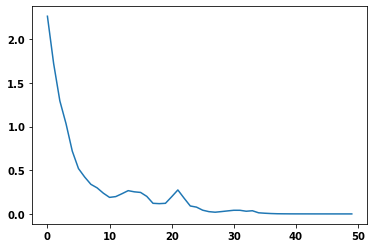

In [36]:
import matplotlib.pyplot as plt
import numpy as np

epochs_range = np.arange(0, epochs)
plt.plot(epochs_range, loss0['train'])

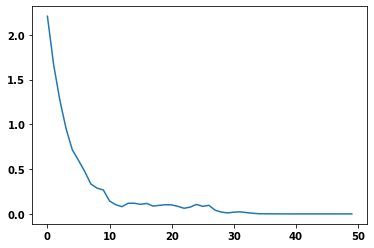

In [37]:
plt.plot(epochs_range, loss1['train'])

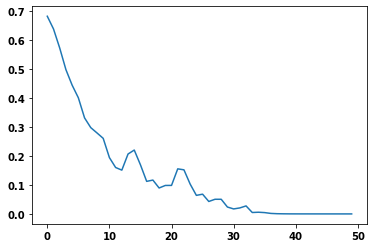

In [38]:
plt.plot(epochs_range, loss_class['train'])

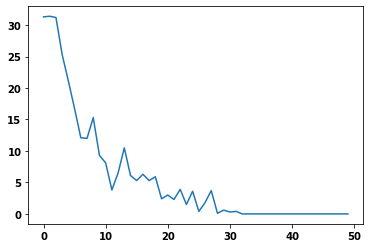

In [39]:
plt.plot(epochs_range, acc['train'])

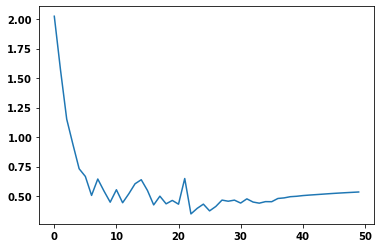

In [40]:
plt.plot(epochs_range, loss0['test'])

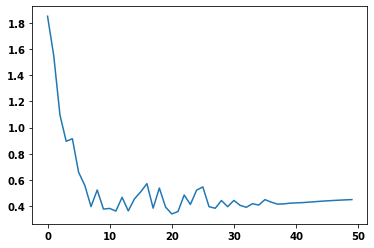

In [41]:
plt.plot(epochs_range, loss1['test'])

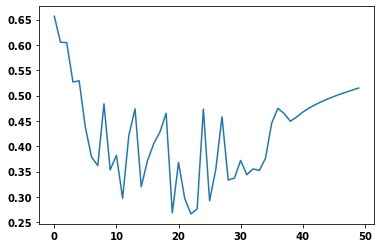

In [42]:
plt.plot(epochs_range, loss_class['test'])

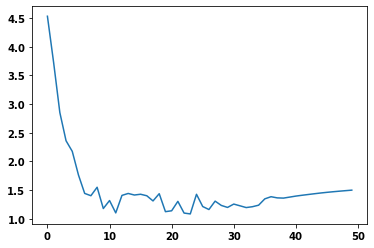

In [43]:
plt.plot(epochs_range, loss_tot['test'])

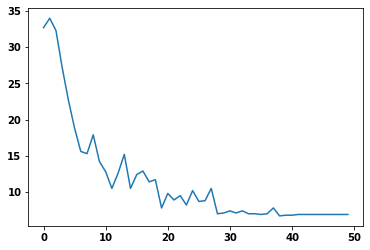

In [44]:
plt.plot(epochs_range, acc['test'])

## Network 3: Adding batch normalization to Siamese net

In [ ]:
class ResNetBlock(nn.Module):
    def __init__(self, nb_channels, kernel_size):
        super(ResNetBlock, self).__init__()

        self.conv1 = nn.Conv2d(nb_channels, nb_channels,
                               kernel_size = kernel_size,
                               padding = (kernel_size - 1) // 2)

        self.bn1 = nn.BatchNorm2d(nb_channels)

        self.conv2 = nn.Conv2d(nb_channels, nb_channels,
                               kernel_size = kernel_size,
                               padding = (kernel_size - 1) // 2)

        self.bn2 = nn.BatchNorm2d(nb_channels)

    def forward(self, x):
        y = self.conv1(x)
        y = self.bn1(y)
        y = F.relu(y)
        y = self.conv2(y)
        y = self.bn2(y)
        y = y + x
        y = F.relu(y)

        return y

######################################################################

class ResNet(nn.Module):

    def __init__(self, nb_residual_blocks, nb_channels,
                 kernel_size = 3, nb_classes = 10):
        super(ResNet, self).__init__()

        self.conv = nn.Conv2d(3, nb_channels,
                              kernel_size = kernel_size,
                              padding = (kernel_size - 1) // 2)
        self.bn = nn.BatchNorm2d(nb_channels)

        self.resnet_blocks = nn.Sequential(
            *(ResNetBlock(nb_channels, kernel_size)
              for _ in range(nb_residual_blocks))
        )

        self.fc = nn.Linear(nb_channels, nb_classes)

    def forward(self, x):
        x = F.relu(self.bn(self.conv(x)))
        x = self.resnet_blocks(x)
        x = F.avg_pool2d(x, 32).view(x.size(0), -1)
        x = self.fc(x)
        return x

In [117]:
class SiameseNetBN(nn.Module):
    def __init__(self, chan1 = 16, chan2 = 32, chan3 = 64, nb_hidden1 = 100, nb_hidden2 = 50, nb_hidden3 = 50, nb_hidden4 = 10):
        super(SiameseNetBN, self).__init__()
        
        self.features = nn.Sequential()
        self.features.add_module("conv_1", nn.Conv2d(1, chan1, kernel_size=3))
        self.features.add_module("relu_1", nn.ReLU())
        self.features.add_module("maxpool_1", nn.MaxPool2d(kernel_size=2))
        self.features.add_module("conv_2", nn.Conv2d(chan1, chan2, kernel_size=2))
        self.features.add_module("relu_2", nn.ReLU())
        self.features.add_module("maxpool2", nn.MaxPool2d(kernel_size=2, dilation=1))
        self.features.add_module("conv_3", nn.Conv2d(chan2, chan3, kernel_size=2))
        self.features.add_module("relu_3", nn.ReLU())
        
        class_size = self.features(torch.empty((1, 1, 14, 14))).shape
        self.linear_size = reduce(multiplicator, list(class_size[1:]))
        
        self.classifier1 = nn.Sequential()
        self.classifier1.add_module("linear_1", nn.Linear(self.linear_size, nb_hidden1))
        self.classifier1.add_module("bn_1", nn.BatchNorm1d(nb_hidden1))
        self.classifier1.add_module("relu_1", nn.ReLU())
        self.classifier1.add_module("dropout_1", nn.Dropout(0.25))
        self.classifier1.add_module("linear_2", nn.Linear(nb_hidden1, nb_hidden2))
        self.classifier1.add_module("bn_2", nn.BatchNorm1d(nb_hidden2))
        self.classifier1.add_module("relu_2", nn.ReLU())
        self.classifier1.add_module("dropout_2", nn.Dropout(0.25))
        self.classifier1.add_module("linear_3", nn.Linear(nb_hidden2, 10))
        
        self.classifier2 = nn.Sequential()
        self.classifier2.add_module("linear_1", nn.Linear(20, nb_hidden3))
        self.classifier2.add_module("bn_1", nn.BatchNorm1d(nb_hidden3))
        self.classifier2.add_module("relu_1", nn.ReLU())
        self.classifier2.add_module("dropout_1", nn.Dropout(0.25))
        self.classifier2.add_module("linear_2", nn.Linear(nb_hidden3, nb_hidden4))
        self.classifier2.add_module("bn_2", nn.BatchNorm1d(nb_hidden4))
        self.classifier2.add_module("relu_2", nn.ReLU())
        self.classifier2.add_module("dropout_2", nn.Dropout(0.25))
        self.classifier2.add_module("linear_3", nn.Linear(nb_hidden4, 2))
        

    def forward(self, x):
        out_aux = []
        for i in range(0, 2):
            x_i = x[:,i,:,:].view((x.shape[0], 1) + tuple(x.shape[2:]))
            x_i = self.features(x_i)
            out_aux.append(self.classifier1(x_i.view(-1, self.linear_size)))
        #diff = out_aux[1] - out_aux[0]
        diff = torch.cat((out_aux[1], out_aux[0]), 1)
        out = self.classifier2(diff)
        return out, out_aux

In [118]:
# Check on the sizes
X = torch.empty((1, 1, 14, 14)).normal_()
net = SiameseNetBN()
for layer in net.features:
    if isinstance(layer, nn.Linear):
        X = X.view(-1, reduce(multiplicator, list(X.shape[1:])))
    X = layer(X)
    print(layer, 'output shape:\t', X.shape)

Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1)) output shape:	 torch.Size([1, 16, 12, 12])
ReLU() output shape:	 torch.Size([1, 16, 12, 12])
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) output shape:	 torch.Size([1, 16, 6, 6])
Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1)) output shape:	 torch.Size([1, 32, 5, 5])
ReLU() output shape:	 torch.Size([1, 32, 5, 5])
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) output shape:	 torch.Size([1, 32, 2, 2])
Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1)) output shape:	 torch.Size([1, 64, 1, 1])
ReLU() output shape:	 torch.Size([1, 64, 1, 1])


In [124]:
def train_siamese(model, train_input, train_target, train_classes, mini_batch_size, criterion, epochs, eta, optim="SGD", momentum = 0, nesterov = False):
    
    if (optim == "SGD"):
        optimizer = torch.optim.SGD(model.parameters(), lr = eta, momentum = momentum, nesterov = nesterov)
    if (optim == "Adam"):
        optimizer = torch.optim.Adam(model.parameters(), lr = eta)
        
    for e in range(0, epochs):
        model.train(True)
        for input_data, target_data, class_data in zip(train_input.split(mini_batch_size), train_target.split(mini_batch_size), train_classes.split(mini_batch_size)):
            output, out_aux = model(input_data)
            loss_out = criterion(output, target_data)
            loss_aux0 = criterion(out_aux[0], class_data[:,0])
            loss_aux1 = criterion(out_aux[1], class_data[:,1])
            loss = loss_out + loss_aux0 + loss_aux1
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

In [125]:
def train_siamese_losses(model, train_input, train_target, train_classes, test_input, test_classes, test_target, 
                         mini_batch_size, criterion, epochs, eta, optim="SGD", momentum = 0, nesterov = False):
    
    if (optim == "SGD"):
        optimizer = torch.optim.SGD(model.parameters(), lr = eta, momentum = momentum, nesterov = nesterov)
    if (optim == "Adam"):
        optimizer = torch.optim.Adam(model.parameters(), lr = eta)
    
    loss0 = {"train": [], "test": []}
    loss1 = {"train": [], "test":[]}
    loss_class = {"train":[], "test":[]}
    loss_tot = {"train": [], "test":[]}
    acc = {"train": [], "test": []}
        
    for e in range(0, epochs):
        loss_sum0_train = 0
        loss_sum1_train = 0
        loss_sumclass_train = 0
        loss_sumtot_train = 0
        
        model.train(True)
        for input_data, target_data, class_data in zip(train_input.split(mini_batch_size), train_target.split(mini_batch_size), train_classes.split(mini_batch_size)):
            output, out_aux = model(input_data)
            loss_out = criterion(output, target_data)
            loss_aux0 = criterion(out_aux[0], class_data[:,0])
            loss_aux1 = criterion(out_aux[1], class_data[:,1])
            loss = loss_out + loss_aux0 + loss_aux1
            
            loss_sum0_train+=loss_aux0
            loss_sum1_train+=loss_aux1
            loss_sumclass_train+=loss_out
            loss_sumtot_train+=loss
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        loss0['train'].append(loss_sum0_train/10)
        loss1['train'].append(loss_sum1_train/10)
        loss_class['train'].append(loss_sumclass_train/10)
        loss_tot['train'].append(loss_sumtot_train/10)
        
        with torch.no_grad():
            acc['train'].append(compute_nb_errors_siamese(model, train_input, train_target, mini_batch_size)/10)
            model.train(False)
            loss_0_test, loss_1_test, loss_class_test, loss_tot_test = compute_losses_test(model, test_input, test_target, test_classes, mini_batch_size)
            loss0['test'].append(loss_0_test)
            loss1['test'].append(loss_1_test)
            loss_class['test'].append(loss_class_test)
            loss_tot['test'].append(loss_tot_test)
            acc['test'].append(compute_nb_errors_siamese(model, test_input, test_target, mini_batch_size)/10)
            
    return loss0, loss1, loss_class, loss_tot, acc

In [126]:
def compute_losses_test(model, test_input, test_target, test_classes, mini_batch_size):
    with torch.no_grad():
        loss_sum0_test = 0
        loss_sum1_test = 0
        loss_sumclass_test = 0
        loss_sumtot_test = 0
        for input_data, target_data, class_data in zip(test_input.split(mini_batch_size), test_target.split(mini_batch_size), test_classes.split(mini_batch_size)):
            output, out_aux = model(input_data)
            loss_out = criterion(output, target_data)
            loss_aux0 = criterion(out_aux[0], class_data[:,0])
            loss_aux1 = criterion(out_aux[1], class_data[:,1])
            loss = loss_out + loss_aux0 + loss_aux1

            loss_sum0_test+=loss_aux0
            loss_sum1_test+=loss_aux1
            loss_sumclass_test+=loss_out
            loss_sumtot_test+=loss
    
    return loss_sum0_test/10, loss_sum1_test/10, loss_sumclass_test/10, loss_sumtot_test/10

In [127]:
def compute_nb_errors_siamese(model, data_input, data_target, mini_batch_size, train = False):
    model.train(train)
    tot_err = 0
    for input_data, target_data in zip(data_input.split(mini_batch_size), data_target.split(mini_batch_size)):
        res, _= model(input_data)
        for i, r in enumerate(res):
            pred = r.max(0)[1].item()
            if(target_data[i])!=pred:
                tot_err+=1
    return tot_err

## SGD 

In [128]:
del model
model = SiameseNetBN().to(device)
criterion = nn.CrossEntropyLoss().to(device)
mini_batch_size = 100
epochs = 50
eta = 0.01
train_siamese(model, train_input, train_target, train_classes, mini_batch_size, criterion, epochs, eta)

In [129]:
compute_nb_errors_siamese(model, train_input, train_target, mini_batch_size, False)

226

In [130]:
compute_nb_errors_siamese(model, test_input, test_target, mini_batch_size, True)

320

### Optimize over eta (simple optimize)

In [132]:
mini_batch_size = 100
epochs = 25
etas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
N = 10
for eta in etas:
    tot_eta = 0
    for i in range(0, N):
        del model
        model = SiameseNetBN().to(device)
        criterion = nn.CrossEntropyLoss().to(device)
        train_siamese(model, train_input, train_target, train_classes, mini_batch_size, criterion, epochs, eta)
        err = compute_nb_errors_siamese(model, test_input, test_target, mini_batch_size, True)
        tot_eta+=err
    print("Eta = {}, avg_err = {}".format(eta, tot_eta/N))

Eta = 1e-05, avg_err = 489.0
Eta = 0.0001, avg_err = 503.0
Eta = 0.001, avg_err = 493.3
Eta = 0.01, avg_err = 335.1
Eta = 0.1, avg_err = 118.4


### Optimize over eta, momentum, nesterov

In [133]:
mini_batch_size = 100
epochs = 25
etas = [1e-4, 1e-3, 1e-2, 1e-1]
momentum = [1e-4, 1e-3, 1e-2, 1e-1]
N = 3
for eta in etas:
    for m in momentum:
        for nest in [False, True]:
            tot_eta = 0
            for i in range(0, N):
                del model
                model = SiameseNetBN().to(device)
                criterion = nn.CrossEntropyLoss().to(device)
                train_siamese(model, train_input, train_target, train_classes, mini_batch_size, criterion, epochs, eta, "SGD", m, nest)
                err = compute_nb_errors_siamese(model, test_input, test_target, mini_batch_size, True)
                tot_eta+=err
            print("Eta = {}, momentum = {}, nesterov = {}, avg_err = {}".format(eta, m, nest, tot_eta/N))

Eta = 0.0001, momentum = 0.0001, nesterov = False, avg_err = 524.6666666666666
Eta = 0.0001, momentum = 0.0001, nesterov = True, avg_err = 500.0
Eta = 0.0001, momentum = 0.001, nesterov = False, avg_err = 492.6666666666667
Eta = 0.0001, momentum = 0.001, nesterov = True, avg_err = 514.6666666666666
Eta = 0.0001, momentum = 0.01, nesterov = False, avg_err = 492.0
Eta = 0.0001, momentum = 0.01, nesterov = True, avg_err = 515.6666666666666
Eta = 0.0001, momentum = 0.1, nesterov = False, avg_err = 501.6666666666667
Eta = 0.0001, momentum = 0.1, nesterov = True, avg_err = 498.0
Eta = 0.001, momentum = 0.0001, nesterov = False, avg_err = 484.0
Eta = 0.001, momentum = 0.0001, nesterov = True, avg_err = 473.3333333333333
Eta = 0.001, momentum = 0.001, nesterov = False, avg_err = 471.6666666666667
Eta = 0.001, momentum = 0.001, nesterov = True, avg_err = 477.6666666666667
Eta = 0.001, momentum = 0.01, nesterov = False, avg_err = 485.0
Eta = 0.001, momentum = 0.01, nesterov = True, avg_err = 495

## Adam

In [134]:
del model
model = SiameseNetBN().to(device)
criterion = nn.CrossEntropyLoss().to(device)
mini_batch_size = 100
epochs = 50
eta = 0.01
train_siamese(model, train_input, train_target, train_classes, mini_batch_size, criterion, epochs, eta, "Adam")

In [135]:
compute_nb_errors_siamese(model, train_input, train_target, mini_batch_size, False)

11

In [136]:
compute_nb_errors_siamese(model, test_input, test_target, mini_batch_size, True)

75

### Optimize over eta (simple optimize)

In [140]:
mini_batch_size = 100
epochs = 25
etas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
N = 10
for eta in etas:
    tot_eta = 0
    for i in range(0, N):
        del model
        model = SiameseNetBN().to(device)
        criterion = nn.CrossEntropyLoss().to(device)
        train_siamese(model, train_input, train_target, train_classes, mini_batch_size, criterion, epochs, eta, "Adam")
        err = compute_nb_errors_siamese(model, test_input, test_target, mini_batch_size, True)
        tot_eta+=err
    print("Eta = {}, avg_err = {}".format(eta, tot_eta/N))

Eta = 1e-05, avg_err = 492.1
Eta = 0.0001, avg_err = 379.3
Eta = 0.001, avg_err = 110.4
Eta = 0.01, avg_err = 81.0
Eta = 0.1, avg_err = 114.0


## Printing losses

In [141]:
del model
model = SiameseNetBN().to(device)
criterion = nn.CrossEntropyLoss().to(device)
mini_batch_size = 100
epochs = 50
eta = 0.005
loss0, loss1, loss_class, loss_tot, acc = train_siamese_losses(model, train_input, train_target, train_classes, test_input, test_classes, test_target, 
                                                               mini_batch_size, criterion, epochs, eta, optim="Adam")

In [142]:
compute_nb_errors_siamese(model, test_input, test_target, mini_batch_size)

45

In [143]:
# Number of params
params = sum([np.prod(p.size()) for p in model.parameters()])
params

24558

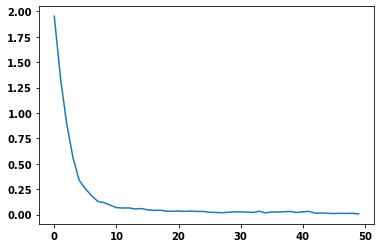

In [144]:
import matplotlib.pyplot as plt
import numpy as np

epochs_range = np.arange(0, epochs)
plt.plot(epochs_range, loss0['train'])

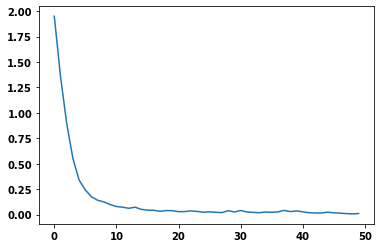

In [145]:
plt.plot(epochs_range, loss1['train'])

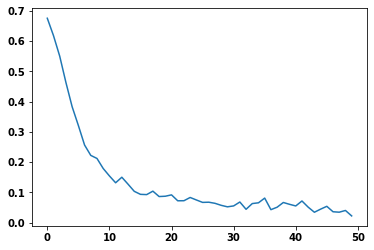

In [146]:
plt.plot(epochs_range, loss_class['train'])

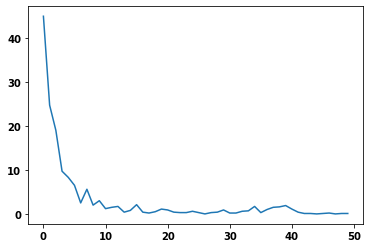

In [147]:
plt.plot(epochs_range, acc['train'])

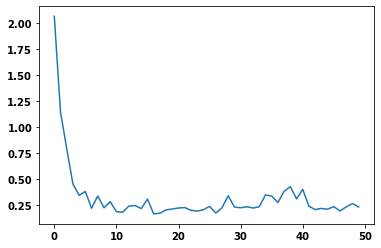

In [148]:
plt.plot(epochs_range, loss0['test'])

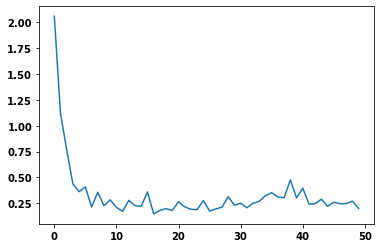

In [149]:
plt.plot(epochs_range, loss1['test'])

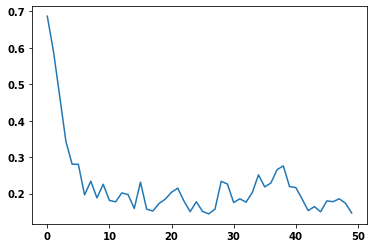

In [150]:
plt.plot(epochs_range, loss_class['test'])

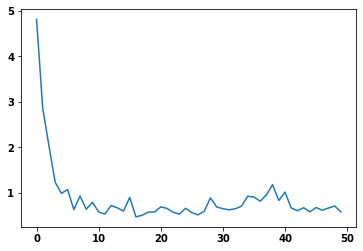

In [151]:
plt.plot(epochs_range, loss_tot['test'])

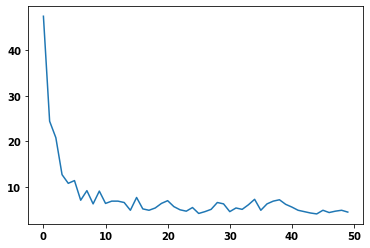

In [152]:
plt.plot(epochs_range, acc['test'])

# Network 4: adding Residual block to BN Siamese

In [153]:
class ResNetBlock(nn.Module):
    def __init__(self, nb_channels, kernel_size):
        super(ResNetBlock, self).__init__()

        self.conv1 = nn.Conv2d(nb_channels, nb_channels,
                               kernel_size = kernel_size,
                               padding = (kernel_size - 1) // 2)

        self.bn1 = nn.BatchNorm2d(nb_channels)

        self.conv2 = nn.Conv2d(nb_channels, nb_channels,
                               kernel_size = kernel_size,
                               padding = (kernel_size - 1) // 2)

        self.bn2 = nn.BatchNorm2d(nb_channels)

    def forward(self, x):
        y = self.conv1(x)
        y = self.bn1(y)
        y = F.relu(y)
        y = self.conv2(y)
        y = self.bn2(y)
        y = y + x
        y = F.relu(y)

        return y

######################################################################

# class ResNet(nn.Module):

#     def __init__(self, nb_residual_blocks, nb_channels,
#                  kernel_size = 3, nb_classes = 10):
#         super(ResNet, self).__init__()

#         self.conv = nn.Conv2d(3, nb_channels,
#                               kernel_size = kernel_size,
#                               padding = (kernel_size - 1) // 2)
#         self.bn = nn.BatchNorm2d(nb_channels)

#         self.resnet_blocks = nn.Sequential(
#             *(ResNetBlock(nb_channels, kernel_size)
#               for _ in range(nb_residual_blocks))
#         )

#         self.fc = nn.Linear(nb_channels, nb_classes)

#     def forward(self, x):
#         x = F.relu(self.bn(self.conv(x)))
#         x = self.resnet_blocks(x)
#         x = F.avg_pool2d(x, 32).view(x.size(0), -1)
#         x = self.fc(x)
#         return x

In [188]:
class SiameseNetBNRes(nn.Module):
    def __init__(self, chan1 = 16, chan2 = 32, chan3 = 64, nb_hidden1 = 100, nb_hidden2 = 50, nb_hidden3 = 50, nb_hidden4 = 10, nb_residual_blocks = 15):
        super(SiameseNetBNRes, self).__init__()
        
        self.features = nn.Sequential()
        self.features.add_module("conv_1", nn.Conv2d(1, chan1, kernel_size=3))
        self.features.add_module("relu_1", nn.ReLU())
        self.features.add_module("maxpool_1", nn.MaxPool2d(kernel_size=2))
        self.features.add_module("conv_2", nn.Conv2d(chan1, chan2, kernel_size=2))
        self.features.add_module("residual_2", nn.Sequential(
            *(ResNetBlock(chan2, 3)
              for _ in range(nb_residual_blocks))
        ))
        self.features.add_module("relu_2", nn.ReLU())
        self.features.add_module("maxpool2", nn.MaxPool2d(kernel_size=2, dilation=1))
        self.features.add_module("conv_3", nn.Conv2d(chan2, chan3, kernel_size=2))
        self.features.add_module("relu_3", nn.ReLU())
        
        class_size = self.features(torch.empty((1, 1, 14, 14))).shape
        self.linear_size = reduce(multiplicator, list(class_size[1:]))
        
        self.classifier1 = nn.Sequential()
        self.classifier1.add_module("linear_1", nn.Linear(self.linear_size, nb_hidden1))
        self.classifier1.add_module("bn_1", nn.BatchNorm1d(nb_hidden1))
        self.classifier1.add_module("relu_1", nn.ReLU())
        self.classifier1.add_module("dropout_1", nn.Dropout(0.25))
        self.classifier1.add_module("linear_2", nn.Linear(nb_hidden1, nb_hidden2))
        self.classifier1.add_module("bn_2", nn.BatchNorm1d(nb_hidden2))
        self.classifier1.add_module("relu_2", nn.ReLU())
        self.classifier1.add_module("dropout_2", nn.Dropout(0.25))
        self.classifier1.add_module("linear_3", nn.Linear(nb_hidden2, 10))
        
        self.classifier2 = nn.Sequential()
        self.classifier2.add_module("linear_1", nn.Linear(20, nb_hidden3))
        self.classifier2.add_module("bn_1", nn.BatchNorm1d(nb_hidden3))
        self.classifier2.add_module("relu_1", nn.ReLU())
        self.classifier2.add_module("dropout_1", nn.Dropout(0.25))
        self.classifier2.add_module("linear_2", nn.Linear(nb_hidden3, nb_hidden4))
        self.classifier2.add_module("bn_2", nn.BatchNorm1d(nb_hidden4))
        self.classifier2.add_module("relu_2", nn.ReLU())
        self.classifier2.add_module("dropout_2", nn.Dropout(0.25))
        self.classifier2.add_module("linear_3", nn.Linear(nb_hidden4, 2))
        

    def forward(self, x):
        out_aux = []
        for i in range(0, 2):
            x_i = x[:,i,:,:].view((x.shape[0], 1) + tuple(x.shape[2:]))
            x_i = self.features(x_i)
            out_aux.append(self.classifier1(x_i.view(-1, self.linear_size)))
        #diff = out_aux[1] - out_aux[0]
        diff = torch.cat((out_aux[1], out_aux[0]), 1)
        out = self.classifier2(diff)
        return out, out_aux

In [189]:
# Check on the sizes
X = torch.empty((1, 1, 14, 14)).normal_()
net = SiameseNetBNRes()
for layer in net.features:
    if isinstance(layer, nn.Linear):
        X = X.view(-1, reduce(multiplicator, list(X.shape[1:])))
    X = layer(X)
    print(layer, 'output shape:\t', X.shape)

Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1)) output shape:	 torch.Size([1, 16, 12, 12])
ReLU() output shape:	 torch.Size([1, 16, 12, 12])
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) output shape:	 torch.Size([1, 16, 6, 6])
Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1)) output shape:	 torch.Size([1, 32, 5, 5])
Sequential(
  (0): ResNetBlock(
    (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): ResNetBlock(
    (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (b

In [168]:
def train_siamese(model, train_input, train_target, train_classes, mini_batch_size, criterion, epochs, eta, optim="SGD", momentum = 0, nesterov = False):
    
    if (optim == "SGD"):
        optimizer = torch.optim.SGD(model.parameters(), lr = eta, momentum = momentum, nesterov = nesterov)
    if (optim == "Adam"):
        optimizer = torch.optim.Adam(model.parameters(), lr = eta)
        
    for e in range(0, epochs):
        model.train(True)
        for input_data, target_data, class_data in zip(train_input.split(mini_batch_size), train_target.split(mini_batch_size), train_classes.split(mini_batch_size)):
            output, out_aux = model(input_data)
            loss_out = criterion(output, target_data)
            loss_aux0 = criterion(out_aux[0], class_data[:,0])
            loss_aux1 = criterion(out_aux[1], class_data[:,1])
            loss = loss_out + loss_aux0 + loss_aux1
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

In [169]:
def train_siamese_losses(model, train_input, train_target, train_classes, test_input, test_classes, test_target, 
                         mini_batch_size, criterion, epochs, eta, optim="SGD", momentum = 0, nesterov = False):
    
    if (optim == "SGD"):
        optimizer = torch.optim.SGD(model.parameters(), lr = eta, momentum = momentum, nesterov = nesterov)
    if (optim == "Adam"):
        optimizer = torch.optim.Adam(model.parameters(), lr = eta)
    
    loss0 = {"train": [], "test": []}
    loss1 = {"train": [], "test":[]}
    loss_class = {"train":[], "test":[]}
    loss_tot = {"train": [], "test":[]}
    acc = {"train": [], "test": []}
        
    for e in range(0, epochs):
        loss_sum0_train = 0
        loss_sum1_train = 0
        loss_sumclass_train = 0
        loss_sumtot_train = 0
        
        model.train(True)
        for input_data, target_data, class_data in zip(train_input.split(mini_batch_size), train_target.split(mini_batch_size), train_classes.split(mini_batch_size)):
            output, out_aux = model(input_data)
            loss_out = criterion(output, target_data)
            loss_aux0 = criterion(out_aux[0], class_data[:,0])
            loss_aux1 = criterion(out_aux[1], class_data[:,1])
            loss = loss_out + loss_aux0 + loss_aux1
            
            loss_sum0_train+=loss_aux0
            loss_sum1_train+=loss_aux1
            loss_sumclass_train+=loss_out
            loss_sumtot_train+=loss
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        loss0['train'].append(loss_sum0_train/10)
        loss1['train'].append(loss_sum1_train/10)
        loss_class['train'].append(loss_sumclass_train/10)
        loss_tot['train'].append(loss_sumtot_train/10)
        
        with torch.no_grad():
            acc['train'].append(compute_nb_errors_siamese(model, train_input, train_target, mini_batch_size)/10)
            model.train(False)
            loss_0_test, loss_1_test, loss_class_test, loss_tot_test = compute_losses_test(model, test_input, test_target, test_classes, mini_batch_size)
            loss0['test'].append(loss_0_test)
            loss1['test'].append(loss_1_test)
            loss_class['test'].append(loss_class_test)
            loss_tot['test'].append(loss_tot_test)
            acc['test'].append(compute_nb_errors_siamese(model, test_input, test_target, mini_batch_size)/10)
            
    return loss0, loss1, loss_class, loss_tot, acc

In [170]:
def compute_losses_test(model, test_input, test_target, test_classes, mini_batch_size):
    with torch.no_grad():
        loss_sum0_test = 0
        loss_sum1_test = 0
        loss_sumclass_test = 0
        loss_sumtot_test = 0
        for input_data, target_data, class_data in zip(test_input.split(mini_batch_size), test_target.split(mini_batch_size), test_classes.split(mini_batch_size)):
            output, out_aux = model(input_data)
            loss_out = criterion(output, target_data)
            loss_aux0 = criterion(out_aux[0], class_data[:,0])
            loss_aux1 = criterion(out_aux[1], class_data[:,1])
            loss = loss_out + loss_aux0 + loss_aux1

            loss_sum0_test+=loss_aux0
            loss_sum1_test+=loss_aux1
            loss_sumclass_test+=loss_out
            loss_sumtot_test+=loss
    
    return loss_sum0_test/10, loss_sum1_test/10, loss_sumclass_test/10, loss_sumtot_test/10

In [171]:
def compute_nb_errors_siamese(model, data_input, data_target, mini_batch_size, train = False):
    model.train(train)
    tot_err = 0
    for input_data, target_data in zip(data_input.split(mini_batch_size), data_target.split(mini_batch_size)):
        res, _= model(input_data)
        for i, r in enumerate(res):
            pred = r.max(0)[1].item()
            if(target_data[i])!=pred:
                tot_err+=1
    return tot_err

## SGD 

In [173]:
del model
model = SiameseNetBNRes().to(device)
criterion = nn.CrossEntropyLoss().to(device)
mini_batch_size = 100
epochs = 50
eta = 0.01
train_siamese(model, train_input, train_target, train_classes, mini_batch_size, criterion, epochs, eta)

In [174]:
compute_nb_errors_siamese(model, train_input, train_target, mini_batch_size, False)

551

In [175]:
compute_nb_errors_siamese(model, test_input, test_target, mini_batch_size, True)

218

### Optimize over eta (simple optimize)

In [132]:
mini_batch_size = 100
epochs = 25
etas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
N = 10
for eta in etas:
    tot_eta = 0
    for i in range(0, N):
        del model
        model = SiameseNetBNRes().to(device)
        criterion = nn.CrossEntropyLoss().to(device)
        train_siamese(model, train_input, train_target, train_classes, mini_batch_size, criterion, epochs, eta)
        err = compute_nb_errors_siamese(model, test_input, test_target, mini_batch_size, True)
        tot_eta+=err
    print("Eta = {}, avg_err = {}".format(eta, tot_eta/N))

Eta = 1e-05, avg_err = 489.0
Eta = 0.0001, avg_err = 503.0
Eta = 0.001, avg_err = 493.3
Eta = 0.01, avg_err = 335.1
Eta = 0.1, avg_err = 118.4


### Optimize over eta, momentum, nesterov

In [ ]:
mini_batch_size = 100
epochs = 25
etas = [1e-4, 1e-3, 1e-2, 1e-1]
momentum = [1e-4, 1e-3, 1e-2, 1e-1]
N = 3
for eta in etas:
    for m in momentum:
        for nest in [False, True]:
            tot_eta = 0
            for i in range(0, N):
                del model
                model = SiameseNetBNRes().to(device)
                criterion = nn.CrossEntropyLoss().to(device)
                train_siamese(model, train_input, train_target, train_classes, mini_batch_size, criterion, epochs, eta, "SGD", m, nest)
                err = compute_nb_errors_siamese(model, test_input, test_target, mini_batch_size, True)
                tot_eta+=err
            print("Eta = {}, momentum = {}, nesterov = {}, avg_err = {}".format(eta, m, nest, tot_eta/N))

Eta = 0.0001, momentum = 0.0001, nesterov = False, avg_err = 524.6666666666666
Eta = 0.0001, momentum = 0.0001, nesterov = True, avg_err = 500.0
Eta = 0.0001, momentum = 0.001, nesterov = False, avg_err = 492.6666666666667
Eta = 0.0001, momentum = 0.001, nesterov = True, avg_err = 514.6666666666666
Eta = 0.0001, momentum = 0.01, nesterov = False, avg_err = 492.0
Eta = 0.0001, momentum = 0.01, nesterov = True, avg_err = 515.6666666666666
Eta = 0.0001, momentum = 0.1, nesterov = False, avg_err = 501.6666666666667
Eta = 0.0001, momentum = 0.1, nesterov = True, avg_err = 498.0


## Adam

In [ ]:
del model
model = SiameseNetBNRes().to(device)
criterion = nn.CrossEntropyLoss().to(device)
mini_batch_size = 100
epochs = 50
eta = 0.01
train_siamese(model, train_input, train_target, train_classes, mini_batch_size, criterion, epochs, eta, "Adam")

In [ ]:
compute_nb_errors_siamese(model, train_input, train_target, mini_batch_size, False)

In [ ]:
compute_nb_errors_siamese(model, test_input, test_target, mini_batch_size, True)

### Optimize over eta (simple optimize)

In [ ]:
mini_batch_size = 100
epochs = 100
etas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
N = 10
for eta in etas:
    tot_eta = 0
    for i in range(0, N):
        del model
        model = SiameseNetBNRes().to(device)
        criterion = nn.CrossEntropyLoss().to(device)
        train_siamese(model, train_input, train_target, train_classes, mini_batch_size, criterion, epochs, eta, "Adam")
        err = compute_nb_errors_siamese(model, test_input, test_target, mini_batch_size, True)
        tot_eta+=err
    print("Eta = {}, avg_err = {}".format(eta, tot_eta/N))

## Printing losses

In [190]:
del model
model = SiameseNetBNRes().to(device)
criterion = nn.CrossEntropyLoss().to(device)
mini_batch_size = 100
epochs = 50
eta = 0.005
loss0, loss1, loss_class, loss_tot, acc = train_siamese_losses(model, train_input, train_target, train_classes, test_input, test_classes, test_target, 
                                                               mini_batch_size, criterion, epochs, eta, optim="Adam")

In [191]:
compute_nb_errors_siamese(model, test_input, test_target, mini_batch_size)

474

In [192]:
# Number of params
params = sum([np.prod(p.size()) for p in model.parameters()])
params

303918

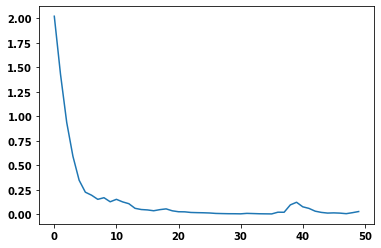

In [193]:
import matplotlib.pyplot as plt
import numpy as np

epochs_range = np.arange(0, epochs)
plt.plot(epochs_range, loss0['train'])

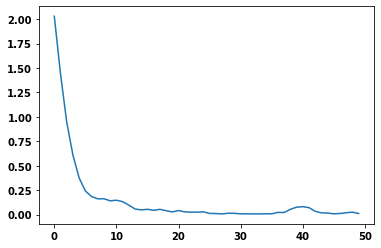

In [194]:
plt.plot(epochs_range, loss1['train'])

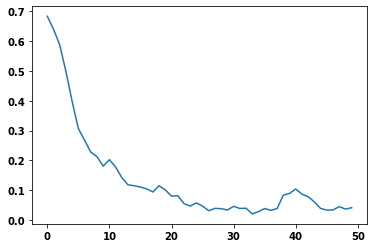

In [195]:
plt.plot(epochs_range, loss_class['train'])

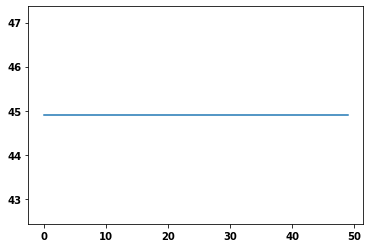

In [196]:
plt.plot(epochs_range, acc['train'])

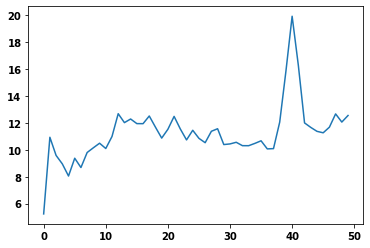

In [197]:
plt.plot(epochs_range, loss0['test'])

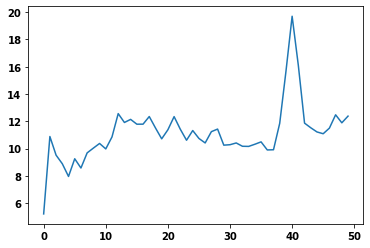

In [198]:
plt.plot(epochs_range, loss1['test'])

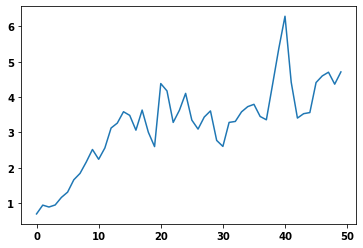

In [199]:
plt.plot(epochs_range, loss_class['test'])

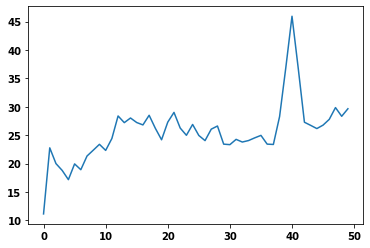

In [200]:
plt.plot(epochs_range, loss_tot['test'])

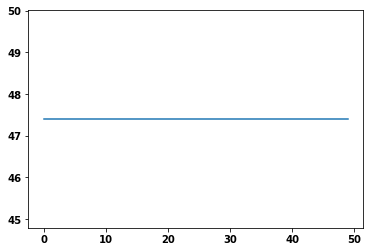

In [201]:
plt.plot(epochs_range, acc['test'])

# OLD

In [109]:
train_input_left = train_input[:,0,:,:].view(N,1,14,14)
train_classes_left = plg.convert_to_one_hot_labels(train_input, train_classes[:,0]).type(torch.LongTensor)
test_input_left = test_input[:,0,:,:].view(N,1,14,14)
test_classes_left = plg.convert_to_one_hot_labels(test_input, test_classes[:,0]).type(torch.LongTensor)

RuntimeError: shape '[10, 1, 14, 14]' is invalid for input of size 196000

In [9]:
def train_model(model, train_input, train_target, mini_batch_size):
    
    if (torch.cuda.is_available()):
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')
        
    model.to(device)
    train_input = train_input.to(device)
    train_target = train_target.to(device)
    
    criterion = nn.CrossEntropyLoss().to(device)
    eta = 1e-1
    epochs = 250
    optimizer = torch.optim.SGD(model.parameters(), lr = eta)
    
    for e in range(0, epochs):
        for input_data, target_data in zip(train_input.split(mini_batch_size), train_target.split(mini_batch_size)):
            output = model(input_data)
            #print(output)
            loss = criterion(output, target_data)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

In [10]:
def compute_nb_errors(model, input, target, mini_batch_size):
    nb_errors = 0

    for b in range(0, input.size(0), mini_batch_size):
        output = model(input.narrow(0, b, mini_batch_size))
        _, predicted_classes = output.max(1)
        for k in range(mini_batch_size):
            if target[b + k] != predicted_classes[k]:
                nb_errors = nb_errors + 1

    return nb_errors

In [14]:
model = Net()
if (torch.cuda.is_available()):
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
model.to(device)
train_model(model, train_input_left, train_classes[:,0], 100)

In [15]:
compute_nb_errors(model, train_input_left, test_classes[:,0], 100)

RuntimeError: Expected object of backend CPU but got backend CUDA for argument #2 'weight'